**Required Imports**

In [11]:
import numpy as np
from collections import defaultdict
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Word2Vec — SkipGram Network Architecture**

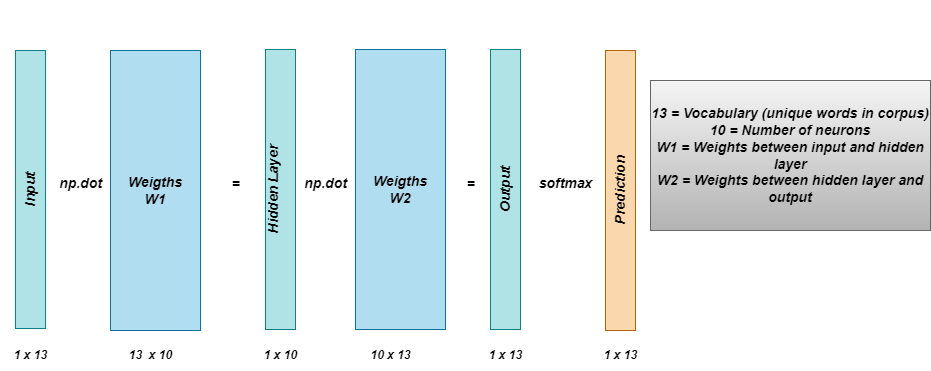

## **Implementation**

 **Corpus**

In [8]:
text = """The Data Lab Community enables data and AI professionals, academics,
 students and other enthusiasts to connect, collaborate and learn from each other."""

**1.) Preprocessing of data**

In [5]:
def preprocessing(corpus):
  stop_words = set(stopwords.words('english'))
  training_data = []
  sentences = corpus.split(".")
  for i in range(len(sentences)):
    sentences[i] = sentences[i].strip()
    sentence = sentences[i].split()
    x = [word.strip(string.punctuation) for word in sentence
									if word not in stop_words]
    x = [word.lower() for word in x]
    training_data.append(x)
  return training_data

In [9]:
corpus = preprocessing(text)

In [10]:
corpus

[['the',
  'data',
  'lab',
  'community',
  'enables',
  'data',
  'ai',
  'professionals',
  'academics',
  'students',
  'enthusiasts',
  'connect',
  'collaborate',
  'learn'],
 []]

**2.) Hypermeters used for training**

In [19]:
hypermeters = {
	'window_size': 2,			# context window +- center word
	'n': 10,					# dimensions of word embeddings, also refer to size of hidden layer
	'epochs': 1000,				# number of training epochs
	'learning_rate': 0.01		# learning rate
}

**3.) Generate Training Data and Model Training**

In [30]:
class word2vec():

	def __init__(self):
		self.n = hypermeters['n']
		self.lr = hypermeters['learning_rate']
		self.epochs = hypermeters['epochs']
		self.window = hypermeters['window_size']

	def generate_training_data(self, hypermeters, corpus):
		# Find unique word counts using dictonary
		word_counts = defaultdict(int)
		for row in corpus:
			for word in row:
				word_counts[word] += 1
		
		# print(word_counts)																																	#
	
		## How many unique words in vocab? 13
		self.v_count = len(word_counts.keys())
		# print(self.v_count)	# 13
		# Generate Lookup Dictionaries (vocab)
		self.words_list = list(word_counts.keys())
		# print(self.words_list)	# uncomment	 to print words																
		#['the', 'data', 'lab', 'community', 'enables', 'ai', 'professionals',
		 #'academics', 'students', 'enthusiasts', 'connect', 'collaborate', 'learn']
		
		# Generate word:index
		self.word_index = dict((word, i) for i, word in enumerate(self.words_list))
	
		# print(self.word_index)	 #  uncomment	 to print words	and index	
	  # {'the': 0, 'data': 1, 'lab': 2, 'community': 3, 'enables': 4, 'ai': 5,
	   #  'professionals': 6, 'academics': 7, 'students': 8, 'enthusiasts': 9, 'connect': 10, 'collaborate': 11, 'learn': 12}

		# Generate index:word
		self.index_word = dict((i, word) for i, word in enumerate(self.words_list))
		# print(self.index_word)	 # uncomment	 to print index and words																							
		# {0: 'the', 1: 'data', 2: 'lab', 3: 'community', 4: 'enables', 5: 'ai', 6: 'professionals', 7: 'academics',
		# 8: 'students', 9: 'enthusiasts', 10: 'connect', 11: 'collaborate', 12: 'learn'}
		training_data = []

		# loop through each sentence in corpus
		for sentence in corpus:
			sent_len = len(sentence)

			# loop through each word in sentence
			for i, word in enumerate(sentence):
				# Convert target word to one-hot
				target_word = self.word2onehot(sentence[i])

				# loop through context word
				context_word = []

				# Note: window_size 2 will have range of 5 values
				for j in range(i - self.window, i + self.window+1):
					# Criteria for context word 
					# 1. Target word cannot be context word (j != i)
					# 2. Index must be greater or equal than 0 (j >= 0) - if not list index out of range
					# 3. Index must be less or equal than length of sentence (j <= sent_len-1) - if not list index out of range 
					# j <= sent_len-1 : j <= sent_len for target word
					if j != i and j <= sent_len-1 and j >= 0:
						# Append the one-hot representation of word to w_context
						context_word.append(self.word2onehot(sentence[j]))
						# print(sentence[i], sentence[j]) 
						# Example:				#
						# tha            data
						# the            lab
						# data           the
						# data           lab
						# data           append	
				# training_data contains a one-hot representation of the target word and context words
				# Example:																						
				# [Target] the, [Context] data, [Context] lab									
				# print(training_data)																			
				# [[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
				 # [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
				  # [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]]	
			
				training_data.append([target_word, context_word])

		return np.array(training_data)

	def word2onehot(self, word):
		# word_vec - initialise a blank vector
		word_vec = [0 for i in range(0, self.v_count)] # Alternative - np.zeros(self.v_count)
		# Get ID of word from word_index
		word_index = self.word_index[word]

		# Change value from 0 to 1 according to ID of the word
		word_vec[word_index] = 1

		return word_vec

	def train(self, training_data):
		# Initialising weight matrices
		# np.random.uniform(HIGH, LOW, OUTPUT_SHAPE)
		self.w1 = np.random.uniform(-1, 1, (self.v_count, self.n))
		self.w2 = np.random.uniform(-1, 1, (self.n, self.v_count))
		
		# Loop through each epoch
		for i in range(self.epochs):
			self.loss = 0  # Intialise loss to 0
			# Loop through each training sample
			# w_t = vector for target word, w_c = vectors for context words
			for w_t, w_c in training_data:
				# Forward pass    --->
				# 1. predicted y using softmax (y_pred)
				# 2. matrix of hidden layer (h) 
				# 3. output layer before softmax (u)
				y_pred, h, u = self.forward_pass(w_t)
				# print("Vector for target word:", w_t)
				# print("W1-before backprop", self.w1)
				# print("W2-before backprop", self.w2)

				# Calculate error
				# 1. For a target word, calculate difference between y_pred and each of the context words
				# 2. Sum up the differences using np.sum to give us the error for this particular target word
				EI = np.sum([np.subtract(y_pred, word) for word in w_c], axis=0)
				# print("Error", EI)	

				# Backpropagation
				# We use SGD to backpropagate errors - calculate loss on the output layer 
				self.backprop(EI, h, w_t)
				#print("W1-after backprop", self.w1)
				#print("W2-after backprop", self.w2)
				# Calculate loss
				# There are 2 parts to the loss function
				# Part 1: -ve sum of all the output +
				# Part 2: length of context words * log of sum for all elements (exponential) in the output layer before softmax (u)
				# Note: word.index(1) returns the index in the context word vector with value 1
				# Note: u[word.index(1)] returns the value of the output layer before softmax
				self.loss += -np.sum([u[word.index(1)] for word in w_c]) + len(w_c) * np.log(np.sum(np.exp(u)))
				# Break if you want to see weights after first target word 	
				# break 									
			print('Epoch:', i, "Loss:", self.loss)

	def forward_pass(self, x):
		# x is one-hot vector for target word, shape - 13x1
		# Run through first matrix (w1) to get hidden layer - 10x13 dot 13x1 gives us 10x1
		h = np.dot(x, self.w1)
		# Dot product hidden layer with second matrix (w2) - 13x10 dot 10x1 gives us 13x1
		u = np.dot(h, self.w2)
		# Run 1x13 through softmax to force each element to range of [0, 1] - 1x12
		y_c = self.softmax(u)
		return y_c, h, u

	def softmax(self, x):
		e_x = np.exp(x - np.max(x))
		return e_x / e_x.sum(axis=0)

	def backprop(self, e, h, x):

		# Column vector EI represents row-wise sum of prediction errors 
		# across each context word for the current center word
		# Going backwards, we need to take derivative of E with respect of w2
		# h - shape 10x1, e - shape 13x1, dl_dw2 - shape 10x13
		# x - shape 13x1, w2 - 10x13, e.T - 13x1
		dl_dw2 = np.outer(h, e)
		dl_dw1 = np.outer(x, np.dot(self.w2, e.T))
		########################################
		# print('Delta for w2', dl_dw2)			
		# print('Hidden layer', h)				
		# print('np.dot', np.dot(self.w2, e.T))	
		# print('Delta for w1', dl_dw1)		
		# Update weights ----->  W (new) = W (old) - (learning_rate)*(derivative of W)
		self.w1 = self.w1 - (self.lr * dl_dw1)
		self.w2 = self.w2 - (self.lr * dl_dw2)

	# Get vector from word
	def word_vec(self, word):
		w_index = self.word_index[word]
		v_w = self.w1[w_index]
		return v_w

	# Input vector, returns nearest word(s)
	def vec_sim(self, word, top_n):
		v_w1 = self.word_vec(word)
		word_sim = {}
		for i in range(self.v_count):
			# Find the similary score for each word in vocab
			v_w2 = self.w1[i]
			theta_sum = np.dot(v_w1, v_w2)
			theta_den = np.linalg.norm(v_w1) * np.linalg.norm(v_w2)
			theta = theta_sum / theta_den
			word = self.index_word[i]
			word_sim[word] = theta

		words_sorted = sorted(word_sim.items(), key=lambda kv: kv[1], reverse=True)

		for word, sim in words_sorted[:top_n]:
			print(word, sim)
# Initialise object
w2v = word2vec()

# Numpy ndarray with one-hot representation for [target_word, context_words]
training_data = w2v.generate_training_data(hypermeters, corpus)

# Training
w2v.train(training_data)

<ipython-input-30-be8d1890638b>:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(training_data)


Epoch: 0 Loss: 151.38996973576377
Epoch: 1 Loss: 147.40338728044387
Epoch: 2 Loss: 143.84748898471844
Epoch: 3 Loss: 140.64169692254956
Epoch: 4 Loss: 137.72514035440096
Epoch: 5 Loss: 135.05073535247766
Epoch: 6 Loss: 132.58133891749077
Epoch: 7 Loss: 130.28716986256453
Epoch: 8 Loss: 128.14402699752168
Epoch: 9 Loss: 126.13202458151288
Epoch: 10 Loss: 124.2346730773247
Epoch: 11 Loss: 122.43819648125759
Epoch: 12 Loss: 120.7310155591139
Epoch: 13 Loss: 119.10334987080468
Epoch: 14 Loss: 117.54690643882476
Epoch: 15 Loss: 116.0546326769332
Epoch: 16 Loss: 114.62051770756284
Epoch: 17 Loss: 113.2394306328777
Epoch: 18 Loss: 111.90698740349775
Epoch: 19 Loss: 110.61944010120482
Epoch: 20 Loss: 109.37358400628834
Epoch: 21 Loss: 108.16667894584202
Epoch: 22 Loss: 106.99638224290544
Epoch: 23 Loss: 105.86069119428757
Epoch: 24 Loss: 104.75789345735619
Epoch: 25 Loss: 103.6865240655891
Epoch: 26 Loss: 102.64532804980756
Epoch: 27 Loss: 101.63322783887578
Epoch: 28 Loss: 100.64929476633964


**4.) Prediction**

In [31]:
# Get vector for word
word = "community"
vec = w2v.word_vec(word)
print(word, vec)

# Find similar words
w2v.vec_sim("community", 3)

community [-1.9573352   0.52295958 -1.4014842  -0.26976004  0.00337592  0.57642956
 -0.23087977  1.0566582  -1.08651191 -0.70362082]
community 1.0
the 0.6037838231221384
ai 0.3511492825255612


**References**
1. ) https://www.geeksforgeeks.org/implement-your-own-word2vecskip-gram-model-in-python/
2. ) https://towardsdatascience.com/an-implementation-guide-to-word2vec-using-numpy-and-google-sheets-13445eebd281